# __[ LG Energy Solution ] <br><br>Anomaly Detection Part2: Recurrunt Auto-Encoder__

# <br>__1. Data: NASA Bearing Dataset__

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/hj-choi-95/Anomaly_Detection_Part2.git

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Step1. 데이터 불러오기

In [2]:
# 데이터 불러오기
data = pd.read_csv('./data/nasa_bearing_dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0,train
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0,train
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0,train
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0,train
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0,train


### Step2. 데이터 Split

In [3]:
X_train = data[data['data_type'] == 'train'].iloc[:, :4]

X_test = data[data['data_type'] == 'test'].iloc[:, :4]
y_test = data[data['data_type'] == 'test'].iloc[:, -2].values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Test data shape: (492, 4)


### Step3. 데이터 정규화

In [4]:
# train 데이터를 기반으로 train/validation/test 데이터에 대하여 min-max scaling 적용 
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

In [5]:
rae_X_train = scaler.transform(X_train)
rae_X_test = scaler.transform(X_test)

---

# __<br>2. Recurrent Auto-Encoder__

### Recurrent Auto-Encoder
>입력과 출력이 동일한 인공신경망 구조 <br>
>정상 데이터에 대한 학습이 충분히 되어 있을 경우 정상 데이터는 자기 자신을 잘 복원할 수 있지만, 이상치 제이터는 학습 기회가 적어 상대적으로 잘 복원하지 못할 것을 가정

<img src="https://i.imgur.com/KpyS57D.jpg" width="700">

In [6]:
import copy
import random
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision

In [7]:
# hyper-parameter 설정
seq_len = 5
input_size = 4
hidden_size = 2

num_epochs = 500
batch_size = 32
learning_rate = 0.00001

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [8]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

### Step 1. DataLoader 만들기

In [9]:
def make_time_series_dataset(X_train, X_test, y_test, seq_len):
    # train/test 데이터를 seq_len 시점 길이로 분할
    datasets = []
    for X in [X_train, X_test]:
        T = X.shape[0]
#         windows = np.split(X[:seq_len * (T // seq_len), :], (T // seq_len))  # (seq_len, input_dim)
#         windows = np.array(windows)
        windows = np.array([X[i:i + seq_len] for i in range(T - seq_len)])
        datasets.append(windows)

    X_train, X_test = datasets[0], datasets[1]
    
    # 각 window의 마지막 시점의 label을 해당 window의 label로 사용
    y_test = np.array([y_test[i + seq_len] for i in range(T - seq_len)])
#     y_test = [y_test[i] for i in list(range(seq_len, seq_len * (T // seq_len) + 1, seq_len))]
    
    # validation/test data 분할
    valid_idx = set(np.random.randint(0, len(X_test), int(len(X_test) * 0.4)))
    X_valid = np.array([X_test[i] for i in valid_idx])
    y_valid = np.array([y_test[i] for i in valid_idx])
    
    test_idx = set(np.arange(len(X_test))) - valid_idx
    X_test = np.array([X_test[i] for i in test_idx])
    y_test = np.array([y_test[i] for i in test_idx])
    
    return X_train, X_valid, X_test, y_valid, y_test, list(valid_idx), list(test_idx)

In [10]:
Xy = make_time_series_dataset(rae_X_train, rae_X_test, y_test, seq_len)
rae_X_train, rae_X_valid, rae_X_test, y_valid, y_test, valid_idx, test_idx = Xy

In [11]:
X_train = X_train.iloc[seq_len:, ]
X_valid = X_test.iloc[valid_idx, :]
X_test = X_test.iloc[test_idx, :]

In [12]:
# train/test dataloader 생성
rae_train_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_train))
rae_train_loader = torch.utils.data.DataLoader(rae_train_dataset, batch_size=batch_size, shuffle=True)

rae_test_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_test))
rae_test_loader = torch.utils.data.DataLoader(rae_test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# validation dataloader의 경우 train/test 단계에서 사용될 loader를 따로 생성함
# train 단계: 정상으로만 구성, test 단계: 정상과 비정상으로 구성
rae_X_valid_train = rae_X_valid[y_valid == 0]
rae_valid_train_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_valid_train))
rae_valid_train_loader = torch.utils.data.DataLoader(rae_valid_train_dataset, batch_size=batch_size, shuffle=False)

rae_valid_test_dataset = torch.utils.data.TensorDataset(torch.Tensor(rae_X_valid))
rae_valid_test_loader = torch.utils.data.DataLoader(rae_valid_test_dataset, batch_size=batch_size, shuffle=False)

### Step 2. 모델 구축

In [14]:
class RecurrentAutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(RecurrentAutoEncoder, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = 1,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size = hidden_size,
            hidden_size = 2 * hidden_size,
            num_layers = 1,
            batch_first = True
        )
        self.fc = nn.Linear(2 * hidden_size, input_size)
                
    def forward(self, x):
        enc_x, (enc_hidden_state, enc_cell_state) = self.encoder(x)
        enc_last_hidden = enc_hidden_state[-1, :, :]
        
        enc_last_hidden = enc_last_hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
        dec_x, (dec_hidden_state, dec_cell_state) = self.decoder(enc_last_hidden)
        dec_x = dec_x.reshape((x.size(0), self.seq_len, -1))
        
        out = self.fc(dec_x)
        out = torch.sigmoid(out)
        return out

In [15]:
rae_model = RecurrentAutoEncoder(input_size, hidden_size, seq_len)

### Step 3. Train 데이터로 모델 학습

In [16]:
# model 학습
def train_model(dataloaders, model, criterion, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_valid_loss = 10000000

    for epoch in range(num_epochs):
        if epoch == 0 or (epoch + 1) % 50 == 0:
            print()
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for i, inputs in enumerate(dataloaders[phase]):
                inputs = inputs[0].to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_total += inputs.size(0)

            # epoch의 loss 및 accuracy 도출
            epoch_loss = running_loss / running_total

            if epoch == 0 or (epoch + 1) % 50 == 0:
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_loss < best_valid_loss:
                best_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    print('Best validation loss: {:4f}'.format(best_valid_loss))
    model.load_state_dict(best_model_wts)
    return model

In [17]:
rae_dataloaders = {'train': rae_train_loader, 'val': rae_valid_train_loader}
rae_train_criterion = nn.MSELoss()
rae_model = train_model(rae_dataloaders, rae_model, rae_train_criterion, num_epochs, learning_rate, device)


Epoch 1/500
train Loss: 0.0399
val Loss: 1.6344

Epoch 50/500
train Loss: 0.0392
val Loss: 1.6292

Epoch 100/500
train Loss: 0.0385
val Loss: 1.6238

Epoch 150/500
train Loss: 0.0379
val Loss: 1.6184

Epoch 200/500
train Loss: 0.0372
val Loss: 1.6131

Epoch 250/500
train Loss: 0.0366
val Loss: 1.6078

Epoch 300/500
train Loss: 0.0360
val Loss: 1.6025

Epoch 350/500
train Loss: 0.0355
val Loss: 1.5971

Epoch 400/500
train Loss: 0.0349
val Loss: 1.5917

Epoch 450/500
train Loss: 0.0344
val Loss: 1.5865

Epoch 500/500
train Loss: 0.0338
val Loss: 1.5819
Best validation loss: 1.581864


### Step 4. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출 (Inference)

In [18]:
# model 검증
def test_model(data_loader, model, criterion, device):
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        test_loss = []
        for i, inputs in enumerate(data_loader):
            inputs = inputs[0].to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss = loss.reshape(loss.shape[0], -1).mean(axis=1)

            test_loss += list(loss.data.cpu().numpy())
    return test_loss

In [19]:
# train/validation/test 데이터에 대한 최종 결과 도출
rae_test_criterion = nn.L1Loss(reduction='none')
rae_train = test_model(rae_train_loader, rae_model, rae_test_criterion, device)
rae_valid = test_model(rae_valid_test_loader, rae_model, rae_test_criterion, device)
rae_test = test_model(rae_test_loader, rae_model, rae_test_criterion, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

Text(0.5, 1.0, 'Test Data')

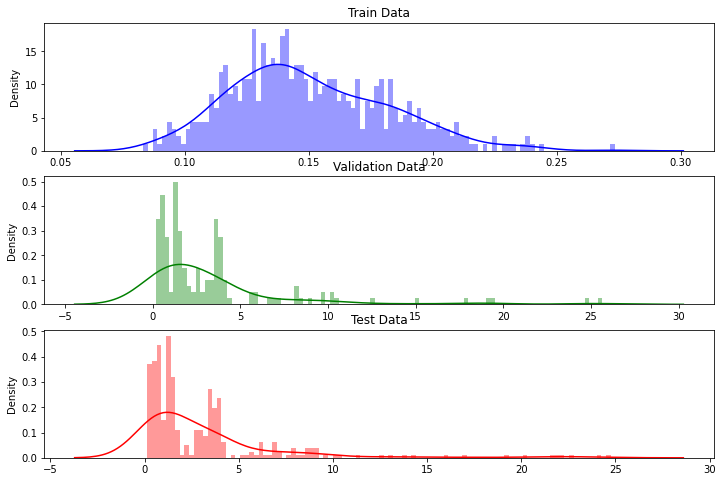

In [20]:
# train/validation/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (12, 8))

sns.distplot(rae_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(rae_valid, bins=100, kde=True, color='green', ax=ax2)
sns.distplot(rae_test, bins=100, kde=True, color='red', ax=ax3)
ax1.set_title("Train Data")
ax2.set_title("Validation Data")
ax3.set_title("Test Data")

### Step 5. Threshold 탐색

In [21]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [22]:
# best threshold 탐색
rae_best_threshold = search_best_threshold(rae_valid, y_valid, num_step=1000)

Best threshold:  1.2862
Best F1 Score: 0.9852


### Step 6. Best threshold를 기반으로 이상치 탐지 모형 평가

In [23]:
# 최종 결과 도출
rae_scores = pd.DataFrame(columns=['score', 'anomaly'])
for date, score in zip([X_train.index, X_valid.index, X_test.index], [rae_train, rae_valid, rae_test]):
    rae_score = pd.DataFrame(index=date)
    rae_score['score'] = score
    rae_score['anomaly'] = rae_best_threshold < score
    rae_scores = rae_scores.append(rae_score)

In [24]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(data.index[int(len(data) * 0.5)], c='orange', ls='--')
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

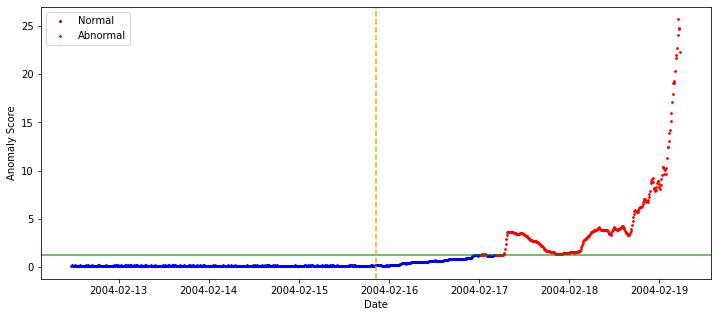

In [25]:
# 전체 기간의 데이터 분포 확인
draw_plot(rae_scores, rae_best_threshold)

In [26]:
# FRR, FAR, F1 score, AUROC, IE 도출
def calculate_metric(y_true, y_pred):
    # FRR, FAR
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    # F1 Score
    f1 = f1_score(y_true, y_pred)
    
    # AUROC, IE
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auroc = auc(fpr, tpr)
    ie = 1 - auroc
    
    return frr, far, f1, auroc, ie

In [27]:
# F1 Score: 0.9772
frr, far, f1, auroc, ie = calculate_metric(y_test, rae_best_threshold < rae_test)

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}  |  AUROC: {}  |  IE: {}"
      .format(round(frr, 4), round(far, 4), round(f1, 4), round(auroc, 4), round(ie, 4)))

**  FRR: 0.0451  |  FAR: 0.0153  |  F1 Score: 0.9772  |  AUROC: 0.9698  |  IE: 0.0302


---